In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [16]:
# Read X_train.csv, X_test.csv, y_train.csv, y_test.csv
X_train = pd.read_csv('Data/X_train.csv')
X_test = pd.read_csv('Data/X_test.csv')
y_train = pd.read_csv('Data/y_train.csv')
y_test = pd.read_csv('Data/y_test.csv')

In [17]:
# check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((730, 29), (314, 29), (730, 1), (314, 1))

In [18]:
from sklearn.metrics import make_scorer, fbeta_score

f2_scorer = make_scorer(fbeta_score, beta=2) # we care recall more than precision

### Decision Tree Classifier

In [19]:
# define a optuna objective function for decision tree classifier
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

def dt_objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 45),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': 66
    }
    dt = DecisionTreeClassifier(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        dt.fit(X_train_op, y_train_op)
        score = f2_scorer(dt, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [20]:
def early_stopping_check(study, trial, early_stopping_rounds=20): # default is to stop study if there are 20 trials without improvement
    current_trial_number = trial.number
    best_trial_number = study.best_trial.number
    should_stop = (current_trial_number - best_trial_number) >= early_stopping_rounds
    if should_stop:
        study.stop()

In [21]:
# run the optimization
from functools import partial

study_dt = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='DecisionTree')
study_dt.optimize(dt_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-02-25 15:52:39,248] A new study created in memory with name: DecisionTree
[I 2024-02-25 15:52:39,267] Trial 0 finished with value: 0.650511193118806 and parameters: {'max_depth': 3, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 0 with value: 0.650511193118806.
[I 2024-02-25 15:52:39,282] Trial 1 finished with value: 0.5938049788764337 and parameters: {'max_depth': 8, 'min_samples_leaf': 45, 'criterion': 'entropy'}. Best is trial 0 with value: 0.650511193118806.
[I 2024-02-25 15:52:39,304] Trial 2 finished with value: 0.6415115854771026 and parameters: {'max_depth': 6, 'min_samples_leaf': 39, 'criterion': 'gini'}. Best is trial 0 with value: 0.650511193118806.
[I 2024-02-25 15:52:39,320] Trial 3 finished with value: 0.677436308901826 and parameters: {'max_depth': 7, 'min_samples_leaf': 34, 'criterion': 'entropy'}. Best is trial 3 with value: 0.677436308901826.
[I 2024-02-25 15:52:39,336] Trial 4 finished with value: 0.6656913140068621 and parameters: {'max_depth

In [22]:
# Best hyperparameters
print('Best hyperparameters:', study_dt.best_params)

Best hyperparameters: {'max_depth': 6, 'min_samples_leaf': 30, 'criterion': 'entropy'}


## Result

In [23]:
# evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

dt = DecisionTreeClassifier(**study_dt.best_params)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.83      0.78       170
           1       0.76      0.65      0.70       144

    accuracy                           0.75       314
   macro avg       0.75      0.74      0.74       314
weighted avg       0.75      0.75      0.74       314

[[141  29]
 [ 51  93]]


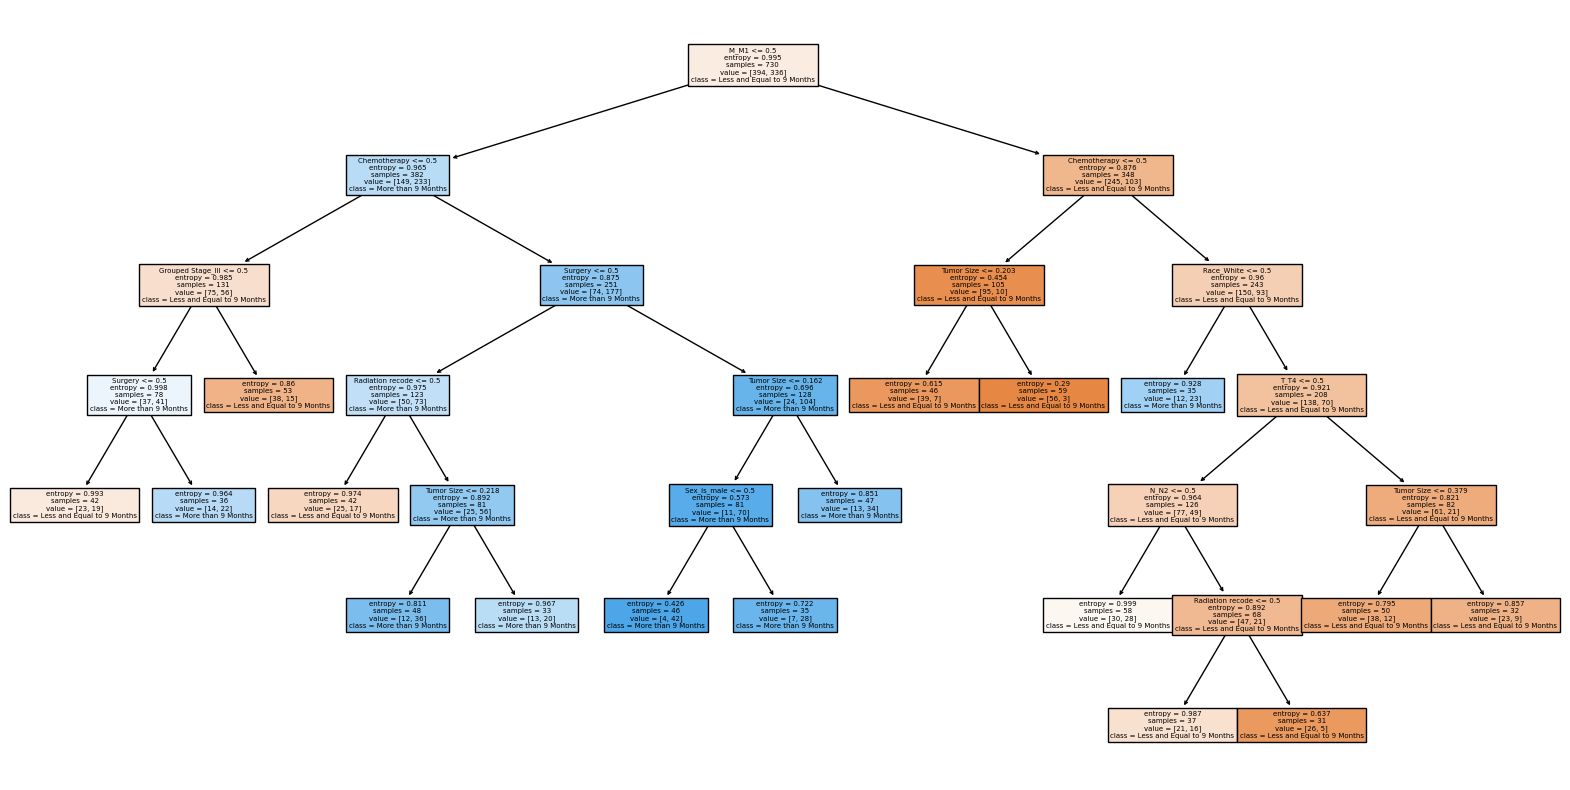

In [24]:
# visualize the tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X_train.columns, class_names=['Less and Equal to 9 Months', 'More than 9 Months'])
plt.show()

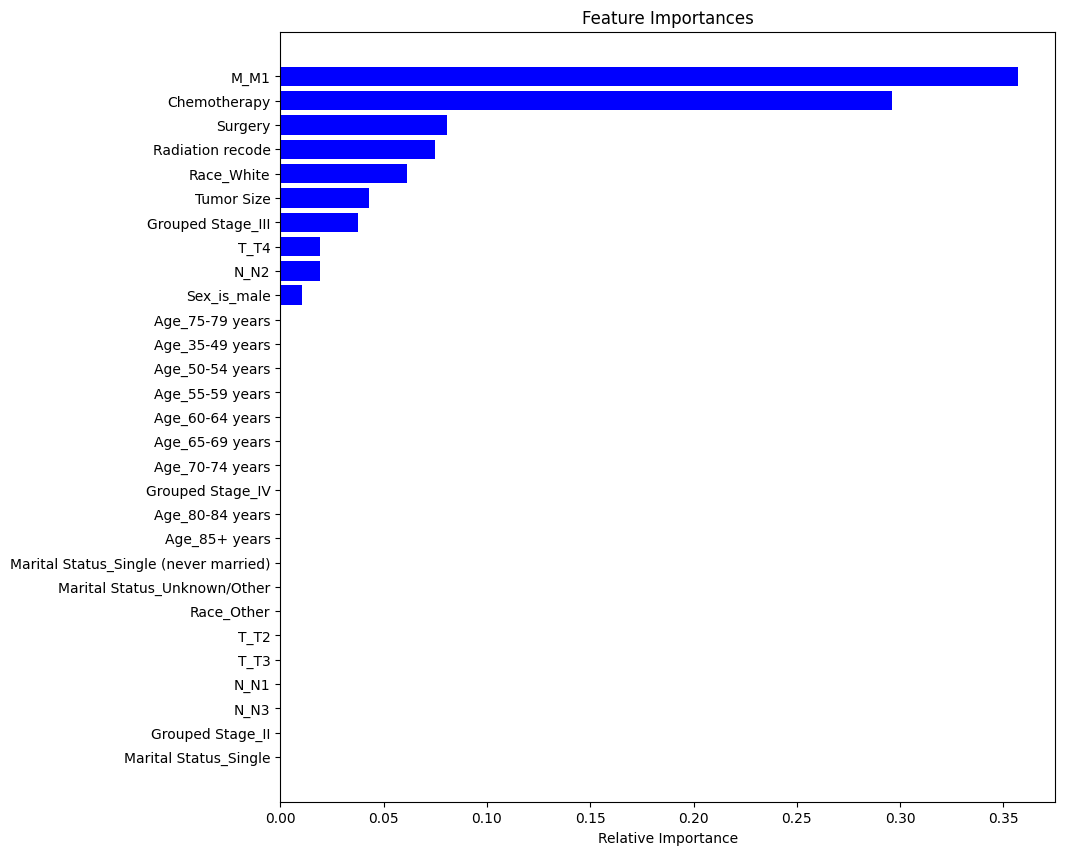

In [25]:
# plot feature importance
importances = dt.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Random Forest Classifier

In [26]:
y_train.shape

(730, 1)

In [30]:
# define a optuna objective function for random forest classifier
from sklearn.ensemble import RandomForestClassifier

def rf_objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 45),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': 66
    }
    rf = RandomForestClassifier(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        y_train_op = y_train_op.squeeze()
        rf.fit(X_train_op, y_train_op)
        score = f2_scorer(rf, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [31]:
# run the optimization
study_rf = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='RandomForest')
study_rf.optimize(rf_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-02-25 15:54:21,719] A new study created in memory with name: RandomForest
[I 2024-02-25 15:54:22,646] Trial 0 finished with value: 0.5928133634914603 and parameters: {'n_estimators': 447, 'max_depth': 8, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5928133634914603.
[I 2024-02-25 15:54:23,334] Trial 1 finished with value: 0.6104643886404518 and parameters: {'n_estimators': 391, 'max_depth': 10, 'min_samples_leaf': 41, 'criterion': 'gini'}. Best is trial 1 with value: 0.6104643886404518.
[I 2024-02-25 15:54:23,838] Trial 2 finished with value: 0.6089472931578195 and parameters: {'n_estimators': 275, 'max_depth': 7, 'min_samples_leaf': 34, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6104643886404518.
[I 2024-02-25 15:54:24,280] Trial 3 finished with value: 0.6053852862913441 and parameters: {'n_estimators': 239, 'max_depth': 5, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 1 with value: 0.6104643886404518.
[I 2024-02-25 1

In [32]:
# Best hyperparameters
print('Best hyperparameters:', study_rf.best_params)

Best hyperparameters: {'n_estimators': 391, 'max_depth': 10, 'min_samples_leaf': 41, 'criterion': 'gini'}


## Result

In [33]:
# evaluate the model
rf = RandomForestClassifier(**study_rf.best_params)
rf.fit(X_train, y_train.squeeze())
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79       170
           1       0.77      0.67      0.72       144

    accuracy                           0.76       314
   macro avg       0.76      0.75      0.75       314
weighted avg       0.76      0.76      0.76       314

[[142  28]
 [ 48  96]]


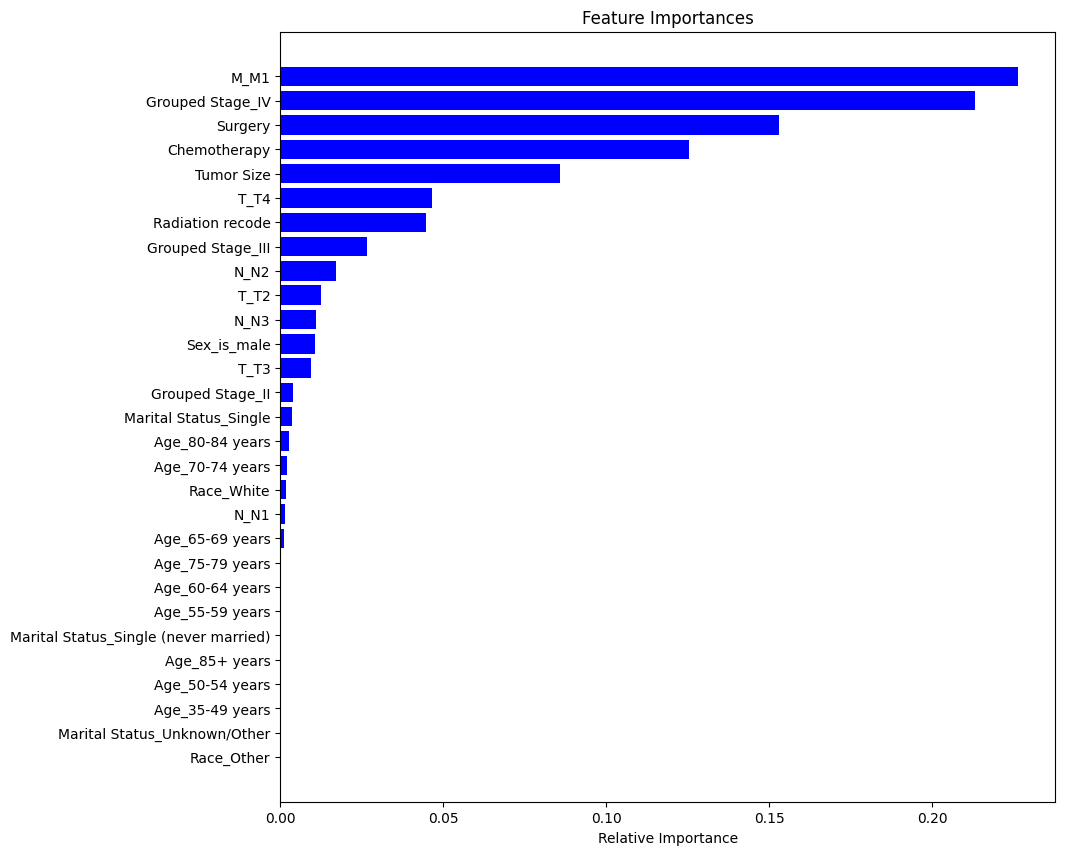

In [34]:
# plot feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## SVM

In [37]:
# define a optuna objective function for SVM
from sklearn.svm import SVC

def svm_objective(trial):
    param = {
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree': trial.suggest_int('degree', 2, 5),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'random_state': 66
    }
    svm = SVC(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        y_train_op = y_train_op.squeeze()
        svm.fit(X_train_op, y_train_op)
        score = f2_scorer(svm, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [38]:
# run the optimization
study_svm = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='SVM')
study_svm.optimize(svm_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-02-25 15:58:37,188] A new study created in memory with name: SVM
[I 2024-02-25 15:58:37,243] Trial 0 finished with value: 0.600887748863081 and parameters: {'C': 15.174473903513631, 'kernel': 'rbf', 'degree': 4, 'gamma': 'scale'}. Best is trial 0 with value: 0.600887748863081.
[I 2024-02-25 15:58:37,275] Trial 1 finished with value: 0.6352117769662949 and parameters: {'C': 2.946594896823426, 'kernel': 'sigmoid', 'degree': 2, 'gamma': 'auto'}. Best is trial 1 with value: 0.6352117769662949.
[I 2024-02-25 15:58:37,303] Trial 2 finished with value: 0.0 and parameters: {'C': 0.001781170746193652, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto'}. Best is trial 1 with value: 0.6352117769662949.
[I 2024-02-25 15:58:37,454] Trial 3 finished with value: 0.605195390474269 and parameters: {'C': 36.74643292384445, 'kernel': 'linear', 'degree': 4, 'gamma': 'auto'}. Best is trial 1 with value: 0.6352117769662949.
[I 2024-02-25 15:58:37,489] Trial 4 finished with value: 0.5346237181967913 an

In [39]:
# Best hyperparameters
print('Best hyperparameters:', study_svm.best_params)

Best hyperparameters: {'C': 0.4716190695636414, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale'}


## Result

In [40]:
# evaluate the model
svm = SVC(**study_svm.best_params)
svm.fit(X_train, y_train.squeeze())
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.76      0.69      0.72       170
           1       0.67      0.75      0.71       144

    accuracy                           0.72       314
   macro avg       0.72      0.72      0.72       314
weighted avg       0.72      0.72      0.72       314

[[117  53]
 [ 36 108]]


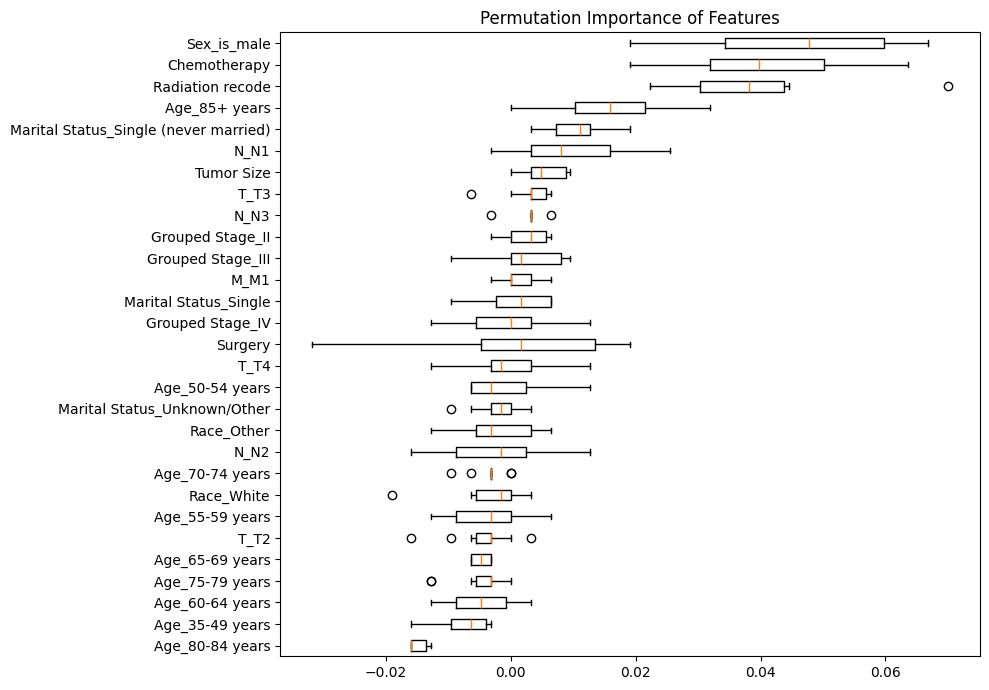

In [43]:
# plot feature importance
from sklearn.inspection import permutation_importance
result = permutation_importance(svm, X_test, y_test, n_repeats=10, random_state=66, n_jobs=-1)

# Get the importances and their standard deviations
importances = result.importances_mean
stds = result.importances_std

feature_names = [X_train.columns[i] for i in result.importances_mean.argsort()]

# Sort the features by importance
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 7))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()

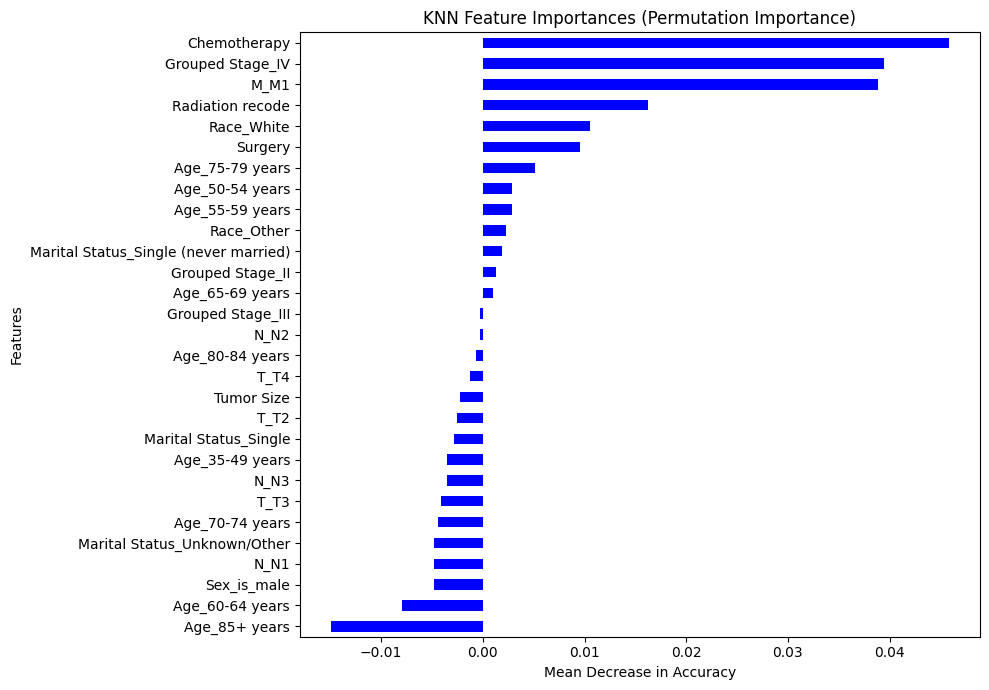

In [61]:
result = permutation_importance(svm, X_test, y_test, n_repeats=10, random_state=66, n_jobs=-1)

# Convert importances into a pandas Series for easier plotting, with feature names as the index
feature_importances_knn = pd.Series(data=result.importances_mean, index=X_train.columns)

# Sorting the importances for visualization
importances_sorted_knn = feature_importances_knn.sort_values()

# Plotting KNN feature importances
plt.figure(figsize=(10, 7))
importances_sorted_knn.plot(kind='barh', color='blue')
plt.title('KNN Feature Importances (Permutation Importance)')
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## KNN

In [44]:
# define a optuna objective function for KNN
from sklearn.neighbors import KNeighborsClassifier

def knn_objective(trial):
    param = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 20),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'p': trial.suggest_int('p', 1, 2),
    }
    knn = KNeighborsClassifier(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        y_train_op = y_train_op.squeeze()
        knn.fit(X_train_op, y_train_op)
        score = f2_scorer(knn, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [45]:
# run the optimization
study_knn = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='KNN')
study_knn.optimize(knn_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-02-25 16:06:14,738] A new study created in memory with name: KNN
[I 2024-02-25 16:06:15,340] Trial 0 finished with value: 0.630599631224642 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'p': 1}. Best is trial 0 with value: 0.630599631224642.
[I 2024-02-25 16:06:15,390] Trial 1 finished with value: 0.5661692577522239 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'p': 2}. Best is trial 0 with value: 0.630599631224642.
[I 2024-02-25 16:06:15,421] Trial 2 finished with value: 0.6347351421135277 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'algorithm': 'kd_tree', 'p': 2}. Best is trial 2 with value: 0.6347351421135277.
[I 2024-02-25 16:06:15,456] Trial 3 finished with value: 0.6029137529137529 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 1}. Best is trial 2 with value: 0.6347351421135277.
[I 2024-02-25 16:06:15,493] Trial 4 finished with value: 0.6394025664794607 a

In [46]:
# Best hyperparameters
print('Best hyperparameters:', study_knn.best_params)


Best hyperparameters: {'n_neighbors': 12, 'weights': 'distance', 'algorithm': 'auto', 'p': 2}


## Result

In [47]:
# evaluate the model
knn = KNeighborsClassifier(**study_knn.best_params)
knn.fit(X_train, y_train.squeeze())
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       170
           1       0.71      0.68      0.69       144

    accuracy                           0.72       314
   macro avg       0.72      0.72      0.72       314
weighted avg       0.72      0.72      0.72       314

[[129  41]
 [ 46  98]]


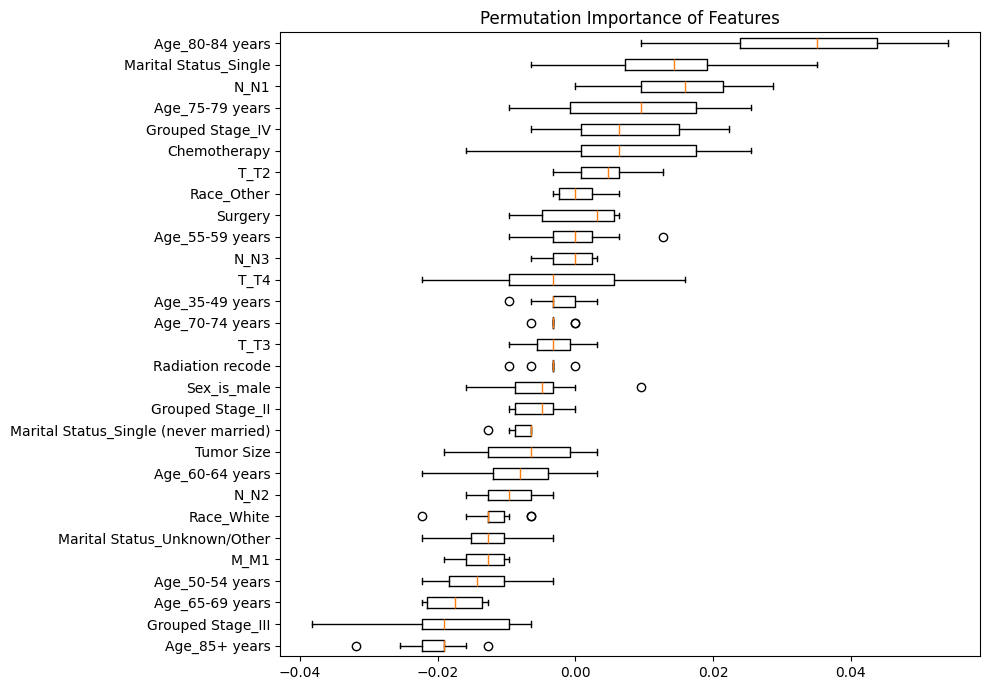

In [49]:
# plot feature importance for KNN
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=66, n_jobs=-1)

# Get the importances and their standard deviations
importances = result.importances_mean
stds = result.importances_std

feature_names = [X_train.columns[i] for i in result.importances_mean.argsort()]

# Sort the features by importance
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 7))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()



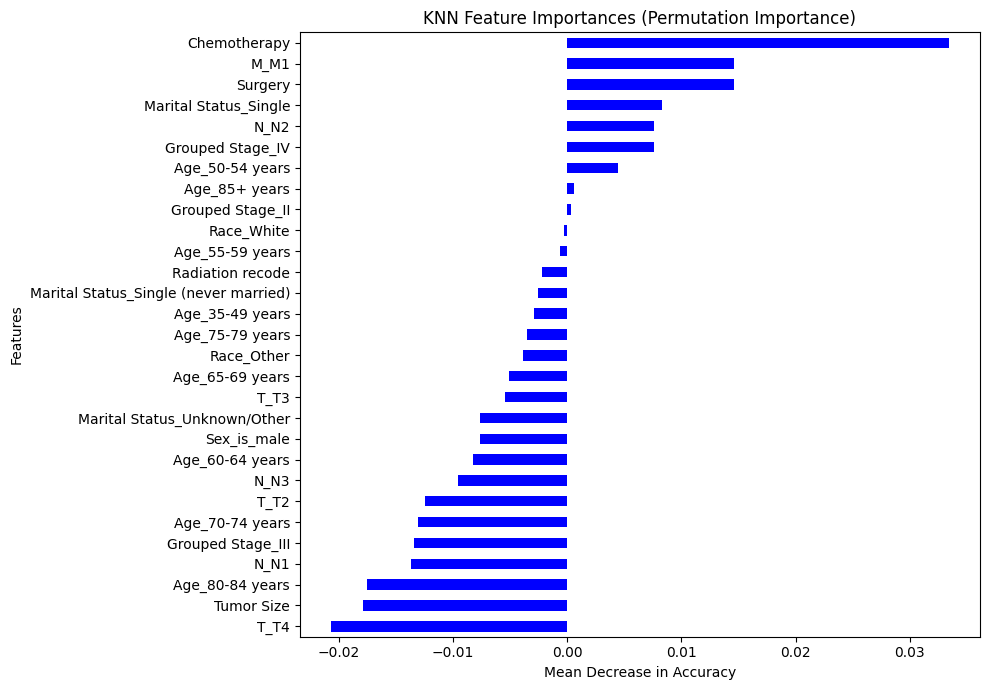

In [59]:
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=66, n_jobs=-1)

# Convert importances into a pandas Series for easier plotting, with feature names as the index
feature_importances_knn = pd.Series(data=result.importances_mean, index=X_train.columns)

# Sorting the importances for visualization
importances_sorted_knn = feature_importances_knn.sort_values()

# Plotting KNN feature importances
plt.figure(figsize=(10, 7))
importances_sorted_knn.plot(kind='barh', color='blue')
plt.title('KNN Feature Importances (Permutation Importance)')
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## Logistic Regression

In [50]:
# define a optuna objective function for logistic regression
from sklearn.linear_model import LogisticRegression

def lr_objective(trial):
    param = {
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'random_state': 66
    }
    lr = LogisticRegression(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        y_train_op = y_train_op.squeeze()
        lr.fit(X_train_op, y_train_op)
        score = f2_scorer(lr, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [51]:
# run the optimization
study_lr = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='LogisticRegression')
study_lr.optimize(lr_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-02-25 16:10:04,820] A new study created in memory with name: LogisticRegression
[I 2024-02-25 16:10:04,837] Trial 0 finished with value: 0.0 and parameters: {'C': 0.008674128581067636, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 0 with value: 0.0.
[I 2024-02-25 16:10:04,856] Trial 1 finished with value: 0.6067484205802794 and parameters: {'C': 12.404204649664097, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.6067484205802794.
[I 2024-02-25 16:10:04,875] Trial 2 finished with value: 0.6095990765471891 and parameters: {'C': 11.463882705921552, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 2 with value: 0.6095990765471891.
[I 2024-02-25 16:10:04,902] Trial 3 finished with value: 0.5936656311148979 and parameters: {'C': 0.043893271409125426, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 2 with value: 0.6095990765471891.
[I 2024-02-25 16:10:04,917] Trial 4 finished with value: 0.5854244140776116 and parameters: {'C': 0.007915950865138315, 

In [52]:
# Best hyperparameters
print('Best hyperparameters:', study_lr.best_params)

Best hyperparameters: {'C': 0.12109798498988629, 'penalty': 'l1', 'solver': 'liblinear'}


## Result

In [53]:
# evaluate the model
lr = LogisticRegression(**study_lr.best_params)
lr.fit(X_train, y_train.squeeze())
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       170
           1       0.75      0.70      0.72       144

    accuracy                           0.75       314
   macro avg       0.75      0.75      0.75       314
weighted avg       0.75      0.75      0.75       314

[[136  34]
 [ 43 101]]


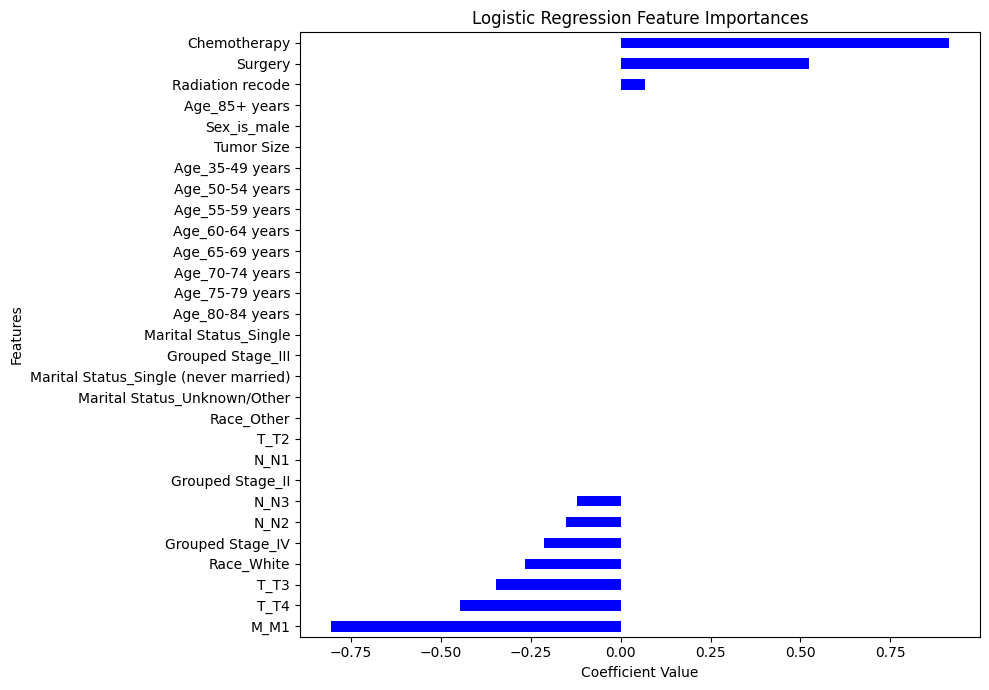

In [60]:
# Plot the feature importances
feature_importances_lr = pd.Series(data=lr.coef_[0], index=X_train.columns)

# Sorting the coefficients for visualization
importances_sorted_lr = feature_importances_lr.sort_values()

# Plotting logistic regression feature importances
plt.figure(figsize=(10, 7))
importances_sorted_lr.plot(kind='barh', color='blue')
plt.title('Logistic Regression Feature Importances')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## LightGBM

In [82]:
from optuna.integration.lightgbm import LightGBMTunerCV as lgbtcv
import lightgbm as lgb
from lightgbm import early_stopping
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [83]:
# Define the custom F2 evaluation function for LightGBM
def lgb_f2_eval(preds, data):
    labels = data.get_label()
    preds = np.round(preds)
    return 'lgb_f2_eval', -fbeta_score(labels, preds, beta=2), False  # Return the negative F2 score

# Parameters for LightGBM
params = {
    "objective": "binary",
    "metric": "lgb_f2_eval",  # Use custom metric
    "boosting_type": "gbdt",
    "verbosity": -1,
}

# Create LightGBM dataset
dtrain= lgb.Dataset(X_train, label=y_train)

study_auto_lgb = optuna.create_study(direction='minimize', study_name='LightGBM Tuner CV')
# Perform cross-validation
auto_lgb_tuner = lgbtcv(
    params=params, 
    train_set=dtrain,  
    num_boost_round=100,  # Number of boosting iterations
    nfold=3,  
    stratified=True,  # Perform stratified sampling
    seed=66,  # Fix random seed for reproducibility of cv
    optuna_seed=66,  # Fix random seed for reproducibility of optuna trials
    shuffle=True,  # Shuffle data before creating folds
    callbacks=[early_stopping(20)],
    study=study_auto_lgb,
    feval=lgb_f2_eval
)


In [84]:
# run the optimization
auto_lgb_tuner.run()

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds


feature_fraction, val_score: -0.641402:  14%|#4        | 1/7 [00:00<00:02,  2.87it/s]

Early stopping, best iteration is:
[37]	cv_agg's valid lgb_f2_eval: -0.641402 + 0.013772
Training until validation scores don't improve for 20 rounds


feature_fraction, val_score: -0.649112:  29%|##8       | 2/7 [00:00<00:01,  3.06it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


feature_fraction, val_score: -0.649112:  43%|####2     | 3/7 [00:00<00:01,  3.22it/s]

Early stopping, best iteration is:
[36]	cv_agg's valid lgb_f2_eval: -0.639107 + 0.030649
Training until validation scores don't improve for 20 rounds


feature_fraction, val_score: -0.649112:  57%|#####7    | 4/7 [00:01<00:01,  2.95it/s]

Early stopping, best iteration is:
[47]	cv_agg's valid lgb_f2_eval: -0.640747 + 0.0162716
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	cv_agg's valid lgb_f2_eval: -0.641615 + 0.0210935


feature_fraction, val_score: -0.649112:  86%|########5 | 6/7 [00:01<00:00,  3.98it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	cv_agg's valid lgb_f2_eval: -0.632171 + 0.0200293
Training until validation scores don't improve for 20 rounds


feature_fraction, val_score: -0.649112: 100%|##########| 7/7 [00:01<00:00,  3.59it/s]


Early stopping, best iteration is:
[20]	cv_agg's valid lgb_f2_eval: -0.640549 + 0.0428283


num_leaves, val_score: -0.649112:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.649112:   5%|5         | 1/20 [00:00<00:07,  2.69it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.649112:  10%|#         | 2/20 [00:00<00:05,  3.05it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.649112:  15%|#5        | 3/20 [00:00<00:05,  3.05it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.649112:  20%|##        | 4/20 [00:01<00:05,  3.12it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.651844:  25%|##5       | 5/20 [00:01<00:04,  3.17it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.651844 + 0.0110453
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.651844:  30%|###       | 6/20 [00:01<00:04,  3.22it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.651844:  35%|###5      | 7/20 [00:02<00:03,  3.29it/s]

Early stopping, best iteration is:
[30]	cv_agg's valid lgb_f2_eval: -0.640038 + 0.00303773
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.651844:  40%|####      | 8/20 [00:02<00:03,  3.13it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.651844:  45%|####5     | 9/20 [00:02<00:03,  2.98it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.651844:  50%|#####     | 10/20 [00:03<00:03,  2.99it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.651844:  55%|#####5    | 11/20 [00:03<00:03,  2.98it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.651844:  60%|######    | 12/20 [00:03<00:02,  3.04it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.655906:  65%|######5   | 13/20 [00:04<00:02,  3.13it/s]

Early stopping, best iteration is:
[35]	cv_agg's valid lgb_f2_eval: -0.655906 + 0.00433063
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.655906:  70%|#######   | 14/20 [00:04<00:01,  3.32it/s]

Early stopping, best iteration is:
[30]	cv_agg's valid lgb_f2_eval: -0.640038 + 0.00303773
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.655906:  75%|#######5  | 15/20 [00:04<00:01,  3.17it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.655906:  80%|########  | 16/20 [00:05<00:01,  3.06it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.655906:  85%|########5 | 17/20 [00:05<00:01,  2.88it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.655906:  90%|######### | 18/20 [00:05<00:00,  3.04it/s]

Early stopping, best iteration is:
[34]	cv_agg's valid lgb_f2_eval: -0.634541 + 0.0260873
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.655906:  95%|#########5| 19/20 [00:06<00:00,  2.94it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: -0.655906: 100%|##########| 20/20 [00:06<00:00,  3.04it/s]


Early stopping, best iteration is:
[31]	cv_agg's valid lgb_f2_eval: -0.649112 + 0.0141826


bagging, val_score: -0.655906:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds


bagging, val_score: -0.655906:  10%|#         | 1/10 [00:00<00:03,  2.75it/s]

Early stopping, best iteration is:
[34]	cv_agg's valid lgb_f2_eval: -0.621348 + 0.030805
Training until validation scores don't improve for 20 rounds


bagging, val_score: -0.655906:  20%|##        | 2/10 [00:00<00:02,  3.06it/s]

Early stopping, best iteration is:
[28]	cv_agg's valid lgb_f2_eval: -0.651063 + 0.0194798
Training until validation scores don't improve for 20 rounds


bagging, val_score: -0.658106:  30%|###       | 3/10 [00:01<00:02,  2.87it/s]

Early stopping, best iteration is:
[33]	cv_agg's valid lgb_f2_eval: -0.658106 + 0.00907011
Training until validation scores don't improve for 20 rounds


bagging, val_score: -0.658106:  40%|####      | 4/10 [00:01<00:02,  2.98it/s]

Early stopping, best iteration is:
[28]	cv_agg's valid lgb_f2_eval: -0.64957 + 0.0260724
Training until validation scores don't improve for 20 rounds


bagging, val_score: -0.658106:  50%|#####     | 5/10 [00:01<00:01,  2.99it/s]

Early stopping, best iteration is:
[36]	cv_agg's valid lgb_f2_eval: -0.648476 + 0.0120186
Training until validation scores don't improve for 20 rounds


bagging, val_score: -0.658106:  60%|######    | 6/10 [00:01<00:01,  3.08it/s]

Early stopping, best iteration is:
[29]	cv_agg's valid lgb_f2_eval: -0.646286 + 0.0128536
Training until validation scores don't improve for 20 rounds


bagging, val_score: -0.662468:  70%|#######   | 7/10 [00:02<00:00,  3.07it/s]

Early stopping, best iteration is:
[37]	cv_agg's valid lgb_f2_eval: -0.662468 + 0.0226862
Training until validation scores don't improve for 20 rounds


bagging, val_score: -0.662468:  80%|########  | 8/10 [00:02<00:00,  3.10it/s]

Early stopping, best iteration is:
[26]	cv_agg's valid lgb_f2_eval: -0.647179 + 0.0222478
Training until validation scores don't improve for 20 rounds


bagging, val_score: -0.662468:  90%|######### | 9/10 [00:02<00:00,  3.25it/s]

Early stopping, best iteration is:
[23]	cv_agg's valid lgb_f2_eval: -0.635036 + 0.0182033
Training until validation scores don't improve for 20 rounds


bagging, val_score: -0.662468: 100%|##########| 10/10 [00:03<00:00,  2.88it/s]


Did not meet early stopping. Best iteration is:
[91]	cv_agg's valid lgb_f2_eval: -0.637264 + 0.00983344


feature_fraction_stage2, val_score: -0.662468:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds


feature_fraction_stage2, val_score: -0.662468:  17%|#6        | 1/6 [00:00<00:01,  2.81it/s]

Early stopping, best iteration is:
[37]	cv_agg's valid lgb_f2_eval: -0.662468 + 0.0226862
Training until validation scores don't improve for 20 rounds


feature_fraction_stage2, val_score: -0.662468:  33%|###3      | 2/6 [00:00<00:01,  2.93it/s]

Early stopping, best iteration is:
[35]	cv_agg's valid lgb_f2_eval: -0.650706 + 0.0158682
Training until validation scores don't improve for 20 rounds


feature_fraction_stage2, val_score: -0.662468:  50%|#####     | 3/6 [00:01<00:00,  3.41it/s]

Early stopping, best iteration is:
[19]	cv_agg's valid lgb_f2_eval: -0.658808 + 0.0193734
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	cv_agg's valid lgb_f2_eval: -0.644655 + 0.0172103


feature_fraction_stage2, val_score: -0.662468:  67%|######6   | 4/6 [00:01<00:00,  3.79it/s]

Training until validation scores don't improve for 20 rounds


feature_fraction_stage2, val_score: -0.662468:  83%|########3 | 5/6 [00:01<00:00,  3.61it/s]

Early stopping, best iteration is:
[20]	cv_agg's valid lgb_f2_eval: -0.644687 + 0.0180797
Training until validation scores don't improve for 20 rounds


feature_fraction_stage2, val_score: -0.662468: 100%|##########| 6/6 [00:01<00:00,  3.59it/s]


Early stopping, best iteration is:
[19]	cv_agg's valid lgb_f2_eval: -0.658808 + 0.0193734


regularization_factors, val_score: -0.662468:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.662468:   5%|5         | 1/20 [00:00<00:06,  3.16it/s]

Early stopping, best iteration is:
[38]	cv_agg's valid lgb_f2_eval: -0.655193 + 0.0230249
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.662468:  10%|#         | 2/20 [00:00<00:06,  2.77it/s]

Early stopping, best iteration is:
[49]	cv_agg's valid lgb_f2_eval: -0.610364 + 0.0432638
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.662468:  15%|#5        | 3/20 [00:01<00:06,  2.52it/s]

Early stopping, best iteration is:
[50]	cv_agg's valid lgb_f2_eval: -0.657283 + 0.0373054
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.662468:  20%|##        | 4/20 [00:01<00:06,  2.62it/s]

Early stopping, best iteration is:
[37]	cv_agg's valid lgb_f2_eval: -0.662468 + 0.0226862
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.662468:  25%|##5       | 5/20 [00:01<00:05,  2.61it/s]

Early stopping, best iteration is:
[37]	cv_agg's valid lgb_f2_eval: -0.662468 + 0.0226862
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.662468:  30%|###       | 6/20 [00:02<00:05,  2.75it/s]

Early stopping, best iteration is:
[37]	cv_agg's valid lgb_f2_eval: -0.662468 + 0.0226862
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.662468:  35%|###5      | 7/20 [00:02<00:04,  2.85it/s]

Early stopping, best iteration is:
[37]	cv_agg's valid lgb_f2_eval: -0.662468 + 0.0226862
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.662468:  40%|####      | 8/20 [00:02<00:04,  2.95it/s]

Early stopping, best iteration is:
[37]	cv_agg's valid lgb_f2_eval: -0.662468 + 0.0226862
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.662468:  45%|####5     | 9/20 [00:03<00:03,  2.85it/s]

Early stopping, best iteration is:
[37]	cv_agg's valid lgb_f2_eval: -0.662468 + 0.0226862
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.662468:  50%|#####     | 10/20 [00:03<00:03,  2.79it/s]

Early stopping, best iteration is:
[37]	cv_agg's valid lgb_f2_eval: -0.662468 + 0.0226862
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.662468:  55%|#####5    | 11/20 [00:03<00:03,  2.78it/s]

Early stopping, best iteration is:
[37]	cv_agg's valid lgb_f2_eval: -0.662468 + 0.0226862
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.662468:  60%|######    | 12/20 [00:04<00:03,  2.56it/s]

Early stopping, best iteration is:
[37]	cv_agg's valid lgb_f2_eval: -0.662468 + 0.0226862
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.663192:  65%|######5   | 13/20 [00:04<00:02,  2.44it/s]

Early stopping, best iteration is:
[39]	cv_agg's valid lgb_f2_eval: -0.663192 + 0.0239887
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.663192:  70%|#######   | 14/20 [00:05<00:02,  2.54it/s]

Early stopping, best iteration is:
[39]	cv_agg's valid lgb_f2_eval: -0.658889 + 0.0222908
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.663192:  75%|#######5  | 15/20 [00:05<00:01,  2.63it/s]

Early stopping, best iteration is:
[39]	cv_agg's valid lgb_f2_eval: -0.663192 + 0.0239887
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.663192:  80%|########  | 16/20 [00:05<00:01,  2.63it/s]

Early stopping, best iteration is:
[39]	cv_agg's valid lgb_f2_eval: -0.663192 + 0.0239887
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.663192:  85%|########5 | 17/20 [00:06<00:01,  2.55it/s]

Early stopping, best iteration is:
[39]	cv_agg's valid lgb_f2_eval: -0.658889 + 0.0222908
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.663192:  90%|######### | 18/20 [00:06<00:00,  2.55it/s]

Early stopping, best iteration is:
[39]	cv_agg's valid lgb_f2_eval: -0.663192 + 0.0239887
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.663192:  95%|#########5| 19/20 [00:07<00:00,  2.60it/s]

Early stopping, best iteration is:
[39]	cv_agg's valid lgb_f2_eval: -0.663192 + 0.0239887
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: -0.663192: 100%|##########| 20/20 [00:07<00:00,  2.63it/s]


Early stopping, best iteration is:
[39]	cv_agg's valid lgb_f2_eval: -0.663192 + 0.0239887


min_child_samples, val_score: -0.663192:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds


min_child_samples, val_score: -0.663192:  20%|##        | 1/5 [00:00<00:01,  2.90it/s]

Early stopping, best iteration is:
[39]	cv_agg's valid lgb_f2_eval: -0.645103 + 0.0233808
Training until validation scores don't improve for 20 rounds


min_child_samples, val_score: -0.663192:  40%|####      | 2/5 [00:00<00:01,  2.86it/s]

Early stopping, best iteration is:
[43]	cv_agg's valid lgb_f2_eval: -0.638709 + 0.0189791
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	cv_agg's valid lgb_f2_eval: -0.602918 + 0.0168238


min_child_samples, val_score: -0.663192:  60%|######    | 3/5 [00:00<00:00,  3.56it/s]

Training until validation scores don't improve for 20 rounds


min_child_samples, val_score: -0.663192:  80%|########  | 4/5 [00:01<00:00,  3.72it/s]

Early stopping, best iteration is:
[17]	cv_agg's valid lgb_f2_eval: -0.647514 + 0.00880999
Training until validation scores don't improve for 20 rounds


min_child_samples, val_score: -0.663192: 100%|##########| 5/5 [00:01<00:00,  3.20it/s]

Early stopping, best iteration is:
[46]	cv_agg's valid lgb_f2_eval: -0.61805 + 0.0445021


In [86]:
# Best hyperparameters
auto_params = auto_lgb_tuner.best_params
auto_best_lgb= lgb.LGBMClassifier(**auto_params, random_state=66)
auto_best_lgb.fit(X_train, y_train)
print('Best hyperparameters:', auto_params)

Best hyperparameters: {'objective': 'binary', 'metric': 'lgb_f2_eval', 'boosting_type': 'gbdt', 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 8.058914493244112e-07, 'lambda_l2': 0.0008321710223267248, 'num_leaves': 10, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.8130945118294259, 'bagging_freq': 4, 'min_child_samples': 20}


## Result

In [88]:
# evaluate the model and print the classification report
# predict the test set
y_pred = auto_best_lgb.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       170
           1       0.72      0.72      0.72       144

    accuracy                           0.74       314
   macro avg       0.74      0.74      0.74       314
weighted avg       0.74      0.74      0.74       314

[[130  40]
 [ 41 103]]


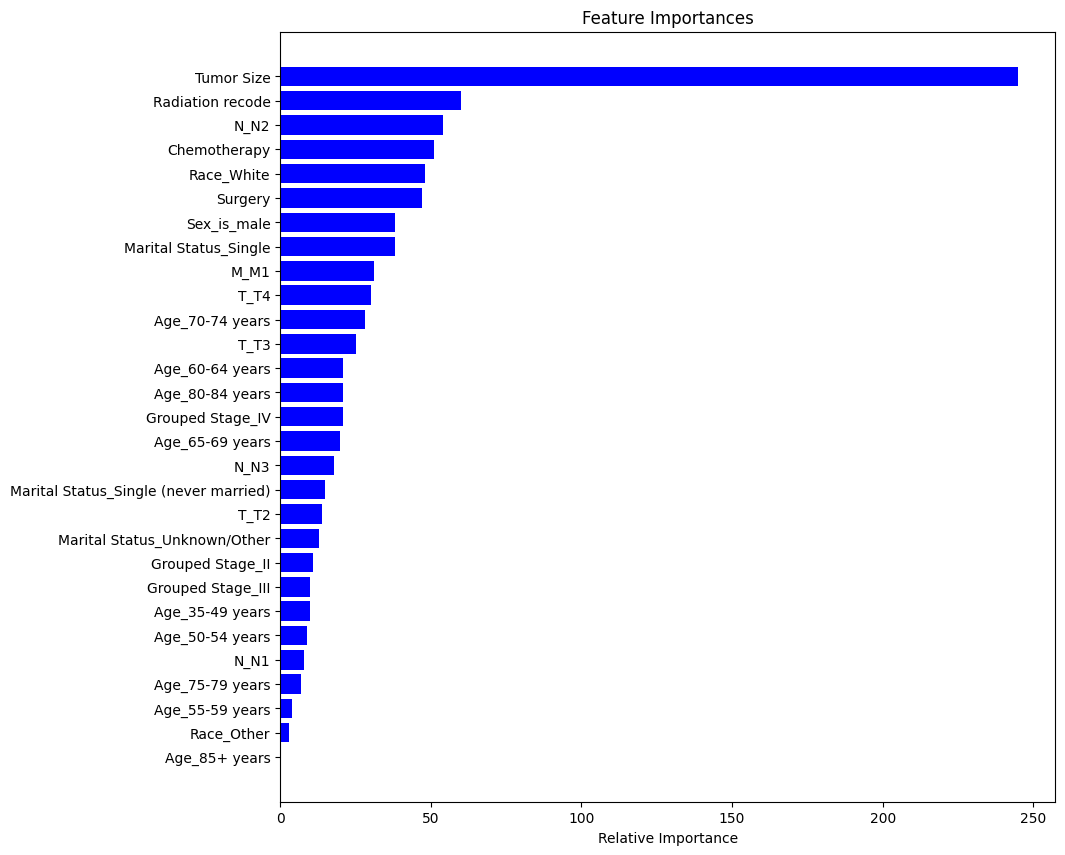

In [89]:
# plot feature importance
importances = auto_best_lgb.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Neural Network

In [280]:
import torch
import torch.nn as nn
import torch.optim as optim

In [281]:
# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 16)  # Hidden layer with 8 neurons
        self.layer2 = nn.Linear(16, 8)           # Hidden layer with 8 neurons
        self.layer3 = nn.Linear(8, 1)           # Output layer for binary classification

    def forward(self, x):
        x = torch.relu(self.layer1(x))  # Activation function for hidden layer
        x = torch.relu(self.layer2(x))  # Activation function for hidden layer
        x = torch.sigmoid(self.layer3(x))  # Sigmoid activation function for output layer
        return x

In [282]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Reshape y to be 2D
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)



In [283]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64  

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [284]:
from torch.optim import lr_scheduler
input_size = X_train.shape[1]
model = SimpleNN(input_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
# Optimizer with a starting learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=5, verbose=True)
num_epochs = 3000
patience = 15

In [285]:
device = 'cpu'

In [286]:
import copy

best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())  # To store the best model weights
counter_early_stopping = 0  # Counter for early stopping
train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        # Forward pass
        predictions = model(data)
        # Calculate loss
        loss = criterion(predictions, target)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss over the epoch
    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # Evaluate the model
    model.eval()  # Set model to evaluate mode
    total_test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            predictions = model(data)
            loss = criterion(predictions, target)
            total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_loss_history.append(avg_test_loss)

    # Print training and test loss
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

    # Check for early stopping
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Epoch {epoch+1} has the best Test Loss: {avg_test_loss}')
        counter_early_stopping = 0
        # Save the best model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, 'best_model_checkpoint.pth')
    else:
        counter_early_stopping += 1
        if counter_early_stopping >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

    # Update the learning rate
    scheduler.step(avg_test_loss)

# Load the best model weights
model.load_state_dict(best_model_wts)


Epoch 1/3000, Training Loss: 0.7132948338985443, Test Loss: 0.7090545415878295
Epoch 1 has the best Test Loss: 0.7090545415878295
Epoch 2/3000, Training Loss: 0.7071364422639211, Test Loss: 0.7018070101737977
Epoch 2 has the best Test Loss: 0.7018070101737977
Epoch 3/3000, Training Loss: 0.7012735605239868, Test Loss: 0.6932958841323853
Epoch 3 has the best Test Loss: 0.6932958841323853
Epoch 4/3000, Training Loss: 0.6930428594350815, Test Loss: 0.6833151459693909
Epoch 4 has the best Test Loss: 0.6833151459693909
Epoch 5/3000, Training Loss: 0.6833963344494501, Test Loss: 0.6714386343955994
Epoch 5 has the best Test Loss: 0.6714386343955994
Epoch 6/3000, Training Loss: 0.6743510613838831, Test Loss: 0.6593639016151428
Epoch 6 has the best Test Loss: 0.6593639016151428
Epoch 7/3000, Training Loss: 0.6630658557017645, Test Loss: 0.6480881571769714
Epoch 7 has the best Test Loss: 0.6480881571769714
Epoch 8/3000, Training Loss: 0.656238908569018, Test Loss: 0.6367516875267029
Epoch 8 has 

Epoch 9/3000, Training Loss: 0.6477156629165014, Test Loss: 0.6265986680984497
Epoch 9 has the best Test Loss: 0.6265986680984497
Epoch 10/3000, Training Loss: 0.6354647527138392, Test Loss: 0.6162058711051941
Epoch 10 has the best Test Loss: 0.6162058711051941
Epoch 11/3000, Training Loss: 0.6357831209897995, Test Loss: 0.6050301790237427
Epoch 11 has the best Test Loss: 0.6050301790237427
Epoch 12/3000, Training Loss: 0.6227090458075205, Test Loss: 0.5963431477546692
Epoch 12 has the best Test Loss: 0.5963431477546692
Epoch 13/3000, Training Loss: 0.6223729799191157, Test Loss: 0.5870752096176147
Epoch 13 has the best Test Loss: 0.5870752096176147
Epoch 14/3000, Training Loss: 0.6076599905888239, Test Loss: 0.5794506669044495
Epoch 14 has the best Test Loss: 0.5794506669044495
Epoch 15/3000, Training Loss: 0.602825274070104, Test Loss: 0.572122311592102
Epoch 15 has the best Test Loss: 0.572122311592102
Epoch 16/3000, Training Loss: 0.5998770097891489, Test Loss: 0.5649129271507263
E

<All keys matched successfully>

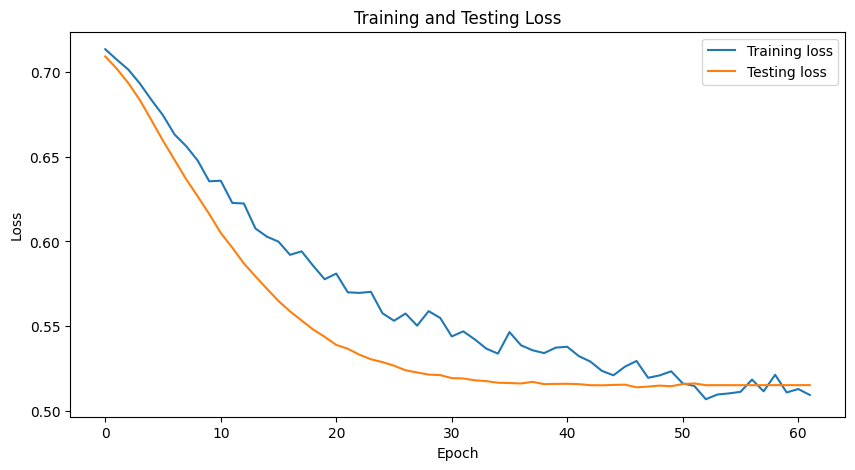

In [287]:
# Plot the training and test loss
plt.plot(train_loss_history, label='Training loss')
plt.plot(test_loss_history, label='Testing loss')
plt.legend()
# fix the size of the plot
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [288]:
model.eval()

SimpleNN(
  (layer1): Linear(in_features=29, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=1, bias=True)
)

## Result

In [289]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = (y_pred > 0.5).float()  # Convert to binary predictions

# Print the classification report
print(classification_report(y_test_tensor, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_test_tensor, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       170
         1.0       0.76      0.71      0.73       144

    accuracy                           0.76       314
   macro avg       0.76      0.76      0.76       314
weighted avg       0.76      0.76      0.76       314

[[137  33]
 [ 42 102]]


| Model               | Accuracy | Precision for Class 0 | Recall for Class 0 | F1-score |
|--------------------|---------|----------------------|--------------------|-----------|
| Decision Tree       | 0.75    | 0.73                  | 0.83                | 0.74      |
| RandomForest        | 0.76    | 0.75                  | 0.84                | 0.75      |
| SVM                 | 0.72    | 0.76                  | 0.69                | 0.72      |
| KNN                 | 0.72    | 0.74                  | 0.76                | 0.72      |
| LogisticRegression | 0.75    | 0.76                  | 0.70                | 0.80      |
| LightGBM            | 0.74    | 0.76                  | 0.76                | 0.74      |
| MLP                 | 0.76    | 0.77                  | 0.81                | 0.76      |


## lift chart for the best model - random forest

In [293]:
import kds

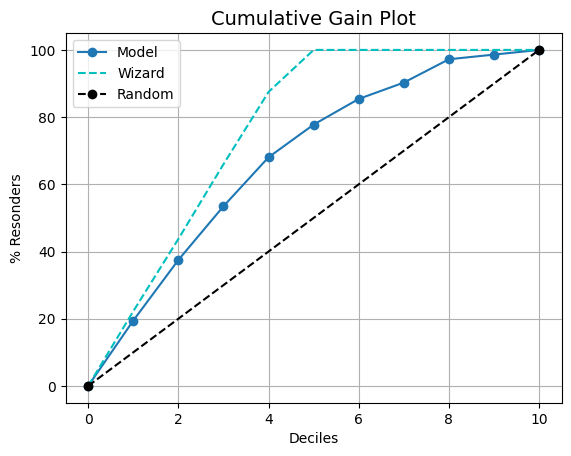

In [297]:
rf = RandomForestClassifier(**study_rf.best_params)
rf.fit(X_train, y_train.squeeze())
y_prob = rf.predict_proba(X_test)
kds.metrics.plot_cumulative_gain(y_test.squeeze(), y_prob[:,1])
plt.show()

## ROC curve for the best model - random forest

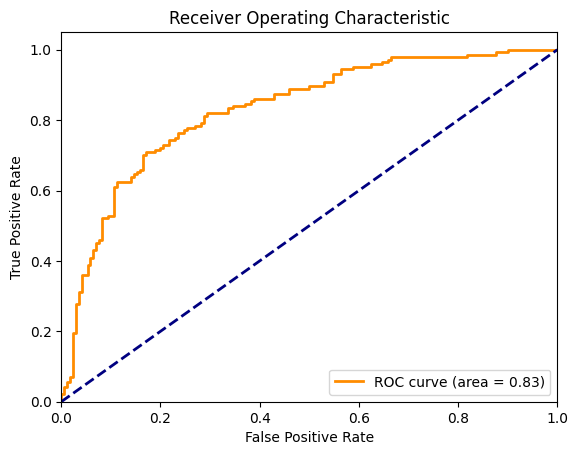

In [301]:
# print out the roc curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])  
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Save all the models

In [303]:
# save all the models
import joblib
joblib.dump(study_dt, 'Models/study_dt.pkl')
joblib.dump(study_rf, 'Models/study_rf.pkl')
joblib.dump(study_svm, 'Models/study_svm.pkl')
joblib.dump(study_knn, 'Models/study_knn.pkl')
joblib.dump(study_lr, 'Models/study_lr.pkl')
joblib.dump(auto_best_lgb, 'Models/auto_best_lgb.pkl')
torch.save(model.state_dict(), 'Models/model_nn_state_dict.pth')
